<h1><center><font size="6">CNN for MNIST</font></center></h1>


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="400"></img>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>     
- <a href='#6'>Conclusions</a>
- <a href='#7'>References</a>
- <a href='#8'>Activity</a>

# <a id="1">Introduction</a>  


## Dataset

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.




## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.   

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.   

The training data sets have 785 columns, the first column being the `label` and it is the digit that was drawn by the user (numbers from 0 to 9 or 10 different classes).

The test data set has 784 columns.

## Solution

We will use a CNN network optimized for the solution of the MNIST problem.


# <a id="2">Load packages</a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [4]:

# Constants
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.1
RANDOM_STATE = 2018
# Model
NO_EPOCHS = 150
PATIENCE = 20
VERBOSE = 1
BATCH_SIZE = 128

# Set this to True if running locally, False for Colab
IS_LOCAL = False

import os

if IS_LOCAL:
    PATH = "input/digit-recognizer/"
else:
    PATH = "/content/drive/MyDrive/BootCamp@PureLogics/Week07_day01/input/"


print("Contents of the specified path:")
print(os.listdir(PATH))

Contents of the specified path:
['test.csv', 'train.csv']


# <a id="3">Read the data</a>

There are 10 different classes of images, one class for each number between 0 and 9.

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate datasets.


In [5]:
train_file = PATH+"train.csv"
test_file  = PATH+"test.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# <a id="4">Data exploration</a>

![](http://)The dimmension of the original  train,  test set are as following:

In [6]:
print("MNIST train -  rows:",train_df.shape[0]," columns:", train_df.shape[1])
print("MNIST test -  rows:",test_df.shape[0]," columns:", test_df.shape[1])

MNIST train -  rows: 42000  columns: 785
MNIST test -  rows: 28000  columns: 784


## <a id="41">Class distribution</a>

Let's see how many number of images are in each class. We start with the train set.

### Train set images class distribution

In [7]:
def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_df)

1:   4684 or 11.152380952380952%
7:   4401 or 10.47857142857143%
3:   4351 or 10.359523809523811%
9:   4188 or 9.971428571428572%
2:   4177 or 9.945238095238096%
6:   4137 or 9.85%
0:   4132 or 9.838095238095237%
4:   4072 or 9.695238095238096%
8:   4063 or 9.673809523809524%
5:   3795 or 9.035714285714286%


The classes are not equaly distributed in the train set (being around 10% each, with values from 9.03% for **5** to 11.15 for **1**).  Let's also plot a graph for these.

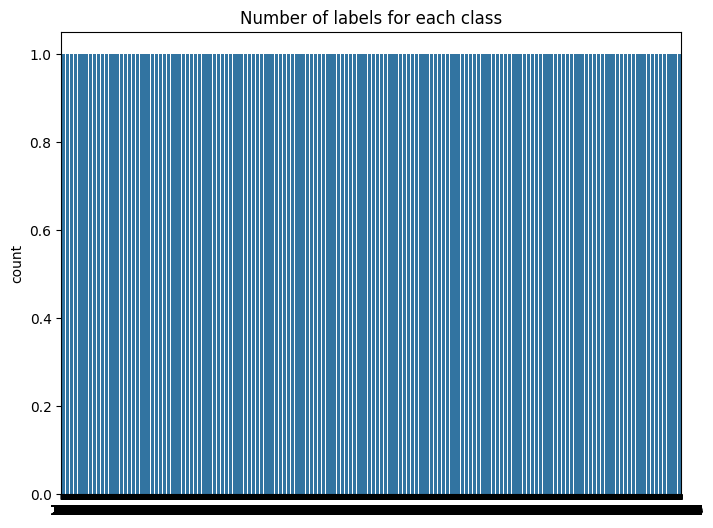

In [8]:
f, ax = plt.subplots(1,1, figsize=(8,6))
g = sns.countplot(train_df.label)
g.set_title("Number of labels for each class")
plt.show()

## <a id="42">Sample images</a>

### Train dataset images

Let's plot some samples for the images.

In [9]:
def sample_images_data(data, hasLabel=True):
    sample_images = []
    sample_labels = []

    if hasLabel:
        for k in range(0, 10):
            samples = data[data["label"] == k].head(4)
            for j, s in enumerate(samples.values):
                img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS, IMG_COLS)
                sample_images.append(img)
                sample_labels.append(samples.iloc[j, 0])
    else:
        import random
        num_rows = len(data)
        sample_count = min(40, num_rows)
        samples = data.iloc[random.sample(range(num_rows), sample_count)]
        for j, s in enumerate(samples.values):
            img = np.array(samples.iloc[j, 0:]).reshape(IMG_ROWS, IMG_COLS)
            sample_images.append(img)
            sample_labels.append(-1)

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_df)

Total number of sample images to plot:  40


Let's now plot the images.

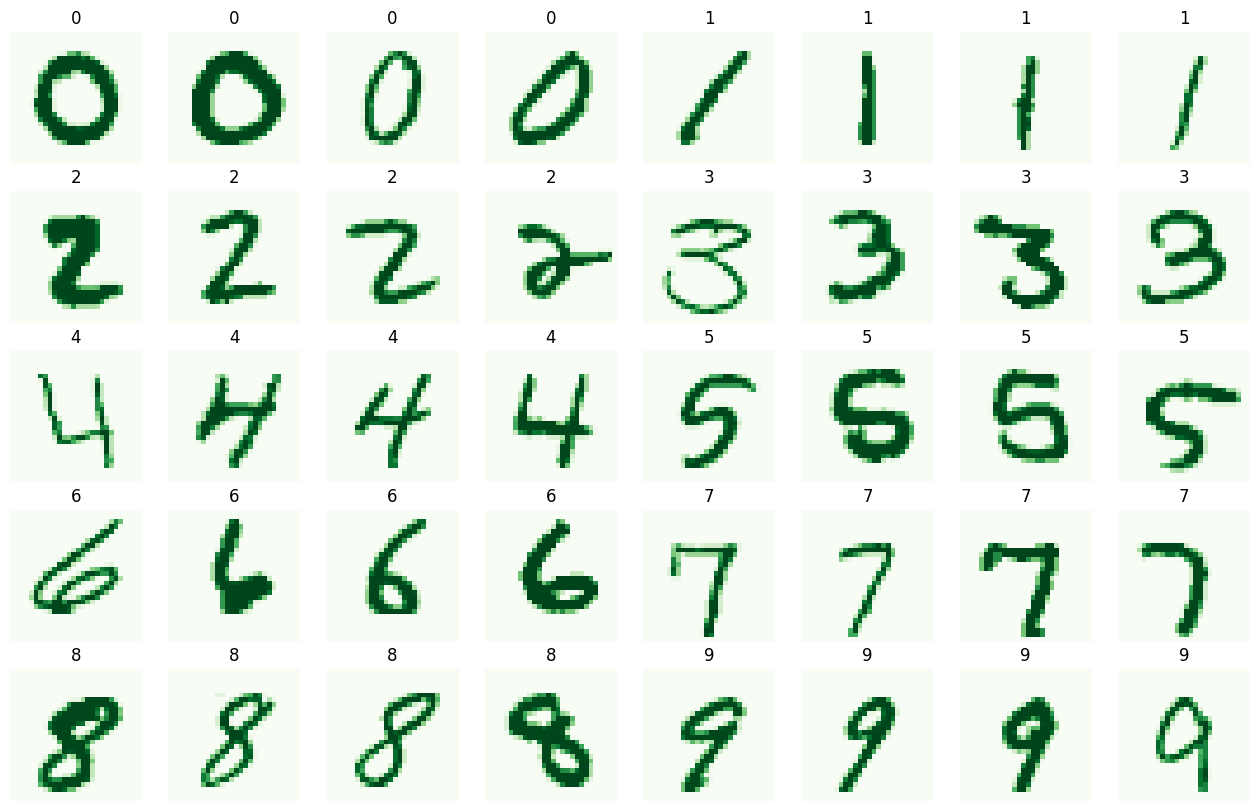

In [10]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(data_sample_labels[i])
    plt.show()

plot_sample_images(train_sample_images,train_sample_labels, "Greens")

### Test set images

Let's plot now a selection of the train set images. We will just randomly select some of the test images, without labeling them, since we do not have the label for the test set. We will print a label of "-1" meaning 'not labeled'.

Total number of sample images to plot:  40


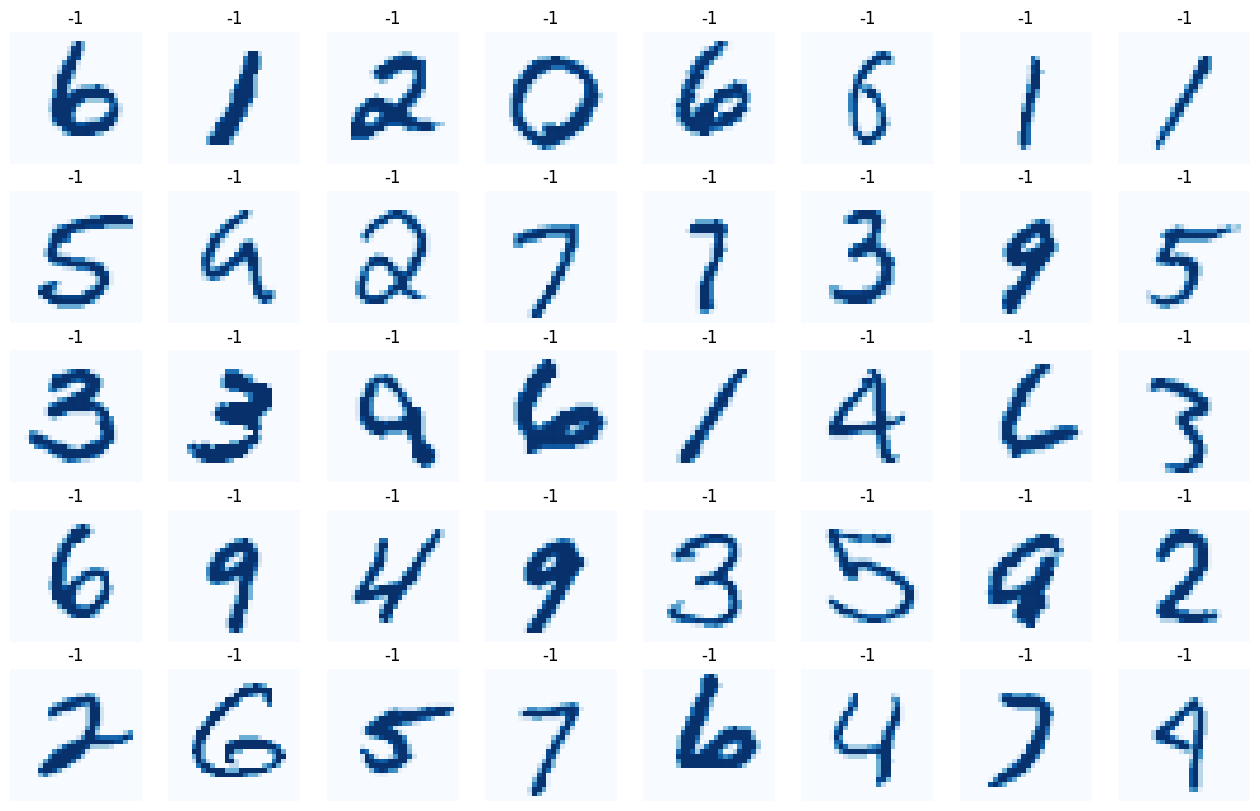

In [11]:
test_sample_images, test_sample_labels = sample_images_data(test_df,hasLabel=False)
plot_sample_images(test_sample_images,test_sample_labels)

# <a id="5">Model</a>

We start with preparing the model.

## <a id="51">Prepare the model</a>

## Data preprocessing

First we will do a data preprocessing to prepare for the model.

We reshape the columns  from (784) to (28,28,1). We also save label (target) feature as a separate vector.

In [12]:
# data preprocessing
def data_preprocessing(raw, hasLabel=True):
    start_pixel = 0
    if(hasLabel):
        start_pixel = 1
    if hasLabel:
      out_y = to_categorical(raw['label'], NUM_CLASSES)
      pixel_data = raw.iloc[:, 1:].values
    else:
      out_y = None
      pixel_data = raw.values

    num_images = raw.shape[0]
    x_as_array = raw.values[:,start_pixel:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

We process both the train_data and the test_data

In [13]:
# prepare the data
X, y = data_preprocessing(train_df)
X = np.nan_to_num(X)

X_test, y_test = data_preprocessing(test_df, hasLabel=False)
X_test = np.nan_to_num(X_test)



print("X range:", np.min(X), np.max(X))  # should be 0.0 to ~1.0
print("NaNs in X:", np.isnan(X).sum())


X range: 0.0 1.0
NaNs in X: 0


## Split train in train and validation set

We further split the train set in train and validation set. The validation set will be 10% from the original train set, therefore the split will be train/validation of 0.9/0.1.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

The dimmension of the processed train, validation and test set are as following:

In [15]:
print("MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

MNIST train -  rows: 37800  columns: (28, 28, 1)
MNIST valid -  rows: 4200  columns: (28, 28, 1)
MNIST test -  rows: 28000  columns: (28, 28, 1)


Let's check the class imbalance for the resulted training set.

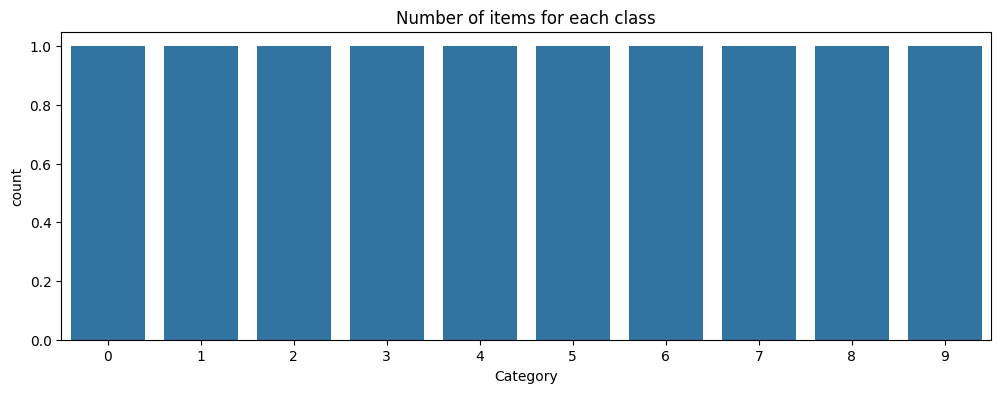

1:   4207 or 11.12962962962963%
7:   3950 or 10.44973544973545%
3:   3881 or 10.267195767195767%
2:   3774 or 9.984126984126984%
9:   3745 or 9.907407407407408%
0:   3734 or 9.878306878306878%
6:   3734 or 9.878306878306878%
4:   3674 or 9.71957671957672%
8:   3640 or 9.62962962962963%
5:   3461 or 9.156084656084657%


In [16]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")

    plt.show()

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{}:   {} or {}%".format(label, count, percent))

plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

Let's see also the class distribution of validation set.

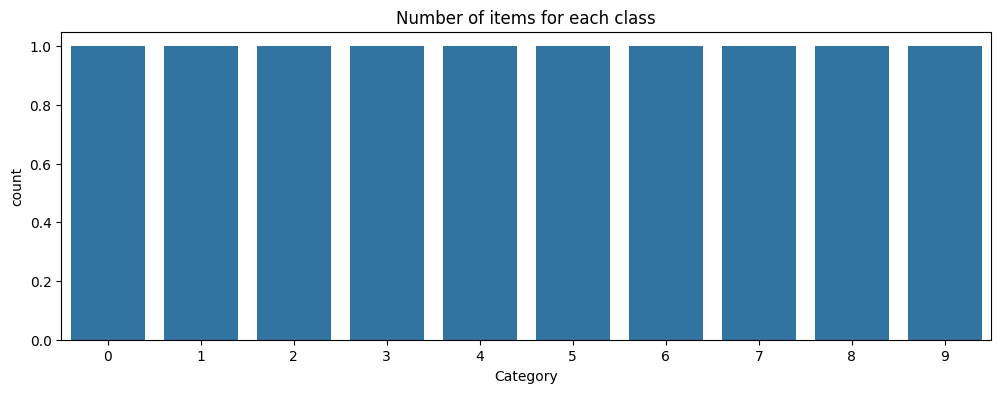

1:   477 or 11.357142857142858%
3:   470 or 11.190476190476192%
7:   451 or 10.738095238095239%
9:   443 or 10.547619047619047%
8:   423 or 10.071428571428571%
6:   403 or 9.595238095238095%
2:   403 or 9.595238095238095%
4:   398 or 9.476190476190476%
0:   398 or 9.476190476190476%
5:   334 or 7.9523809523809526%


In [17]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

## <a id="52">Train the model</a>

### Build the model   



We will use a **Sequential** model.
* The **Sequential** model is a linear stack of layers. It can be first initialized and then we add layers using **add** method or we can add all layers at init stage. The layers added are as follows:

* **Conv2D** is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:
 * filters - the number of filters (Kernels) used with this layer; here filters = 32;
 * kernel_size - the dimmension of the Kernel: (3 x 3);
 * activation - is the activation function used, in this case `relu`;
 * kernel_initializer - the function used for initializing the kernel;
 * input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28
 The input and output of the **Conv2D** is a 4D tensor.
* **Conv2D** with the following parameters:
 * filters: 32;
 * kernel_size: (3 x 3);
 * activation: `relu`;
* **MaxPooling2D** is a Max pooling operation for spatial data. Parameters used here are:
 * *pool_size*, in this case (2,2), representing the factors by which to downscale in both directions;

* **Dropout**. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. The parameter used is:
 * *rate*, set here to 0.25.

* **Conv2D** with the following parameters:
 * filters: 64;
 * kernel_size : (3 x 3);
 * activation : `relu`;

* **MaxPooling2D** with parameter:
 * *pool_size* : (2,2);

* **Dropout**. with parameter:
 * *rate* : 0.25;

* **Conv2D** with the following parameters:
 * filters: 128;
 * kernel_size : (3 x 3);
 * activation : `relu`;

* **Dropout**. with parameter:
 * *rate* : 0.4;

* **Flatten**. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

* **Dense**. This layer is a regular fully-connected NN layer. It is used without parameters;
 * units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
 * activation - activation function : `relu`;

* **Dropout**. with parameter:
 * *rate* : 0.3;

* **Dense**. This is the final layer (fully connected). It is used with the parameters:
 * units: the number of classes (in our case 10);
 * activation : `softmax`; for this final layer it is used `softmax` activation (standard for multiclass classification)


Then we compile the model, specifying as well the following parameters:
* *loss*;
* *optimizer*;
* *metrics*.


In [18]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding="same",
        kernel_initializer='he_normal',input_shape=(IMG_ROWS, IMG_COLS, 1)))

model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
We then compile the model, with the layers and optimized defined.

In [19]:
# Compile the model
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Inspect the model

Let's check the model we initialized.

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,874 (394.04 KB)

 Trainable params: 100,554 (392.79 KB)

 Non-trainable params: 320 (1.25 KB)

Let's also visualize the model using model_plot.

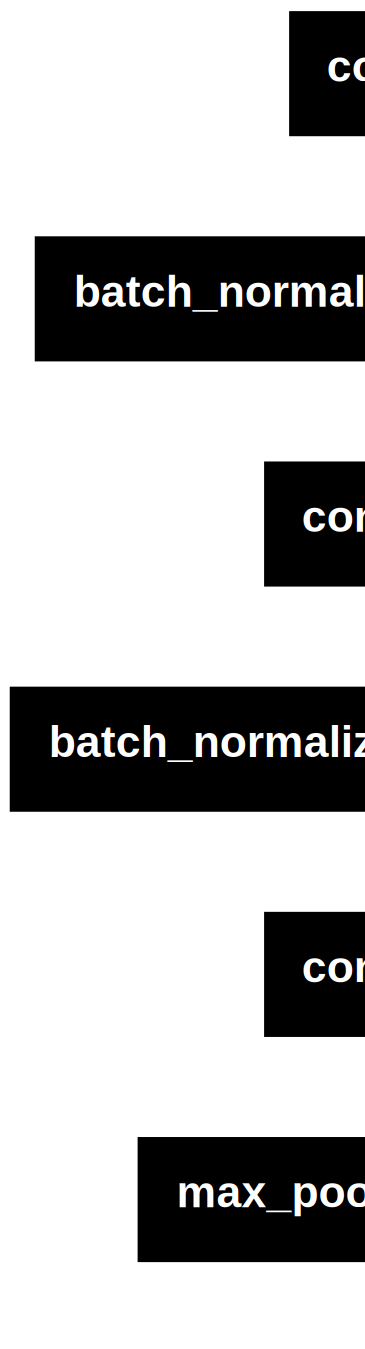

In [21]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Run the model

We run the model with the training set. We are also using the validation set (a subset from the orginal training set) for validation.

In [22]:
NO_EPOCHS = 10

In [23]:
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('model.weights.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)


history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NO_EPOCHS,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[earlystopper, checkpointer])

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5847 - loss: 1.2341
Epoch 1: val_accuracy improved from -inf to 0.89905, saving model to model.weights.h5
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5854 - loss: 1.2321 - val_accuracy: 0.8990 - val_loss: 0.3242
Epoch 2/10
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9526 - loss: 0.1743
Epoch 2: val_accuracy improved from 0.89905 to 0.97786, saving model to model.weights.h5
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9527 - loss: 0.1741 - val_accuracy: 0.9779 - val_loss: 0.0768
Epoch 3/10
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9627 - loss: 0.1292
Epoch 3: val_accuracy improved from 0.97786 to 0.98190, saving model to model.weights.h5
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9627 - loss: 0.1291 - val_accuracy: 0.9819 - val_loss: 0.0613
Epoch 4/10
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9707 - loss: 0.0998
Epoch 4: val_accuracy improved from 0.


## <a id="53">Validation accuracy and  loss </a>


We plot accuracy for validation set compared with the accuracy of training set, for each epoch, on the same graph. Then, we plot loss for validation set compared with the loss for training set.


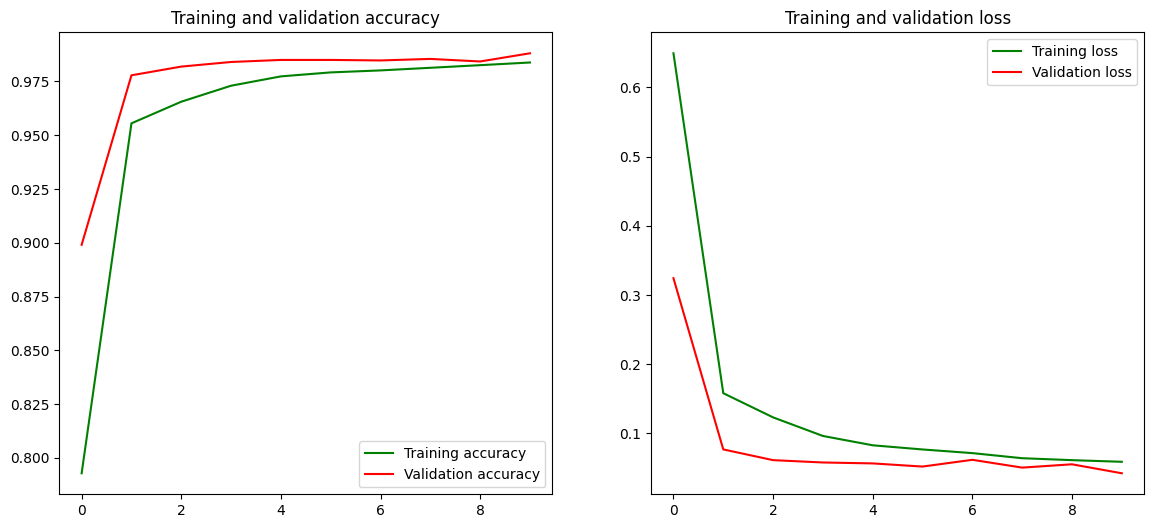

In [24]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist.get('accuracy', hist.get('acc'))  # Handles both keys
    val_acc = hist.get('val_accuracy', hist.get('val_acc'))
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))

    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

    plt.show()

plot_accuracy_and_loss(history)

We can observe that the training is not overfitting, validation accuracy is not decreasing after a certain number of epochs. As well, the validation loss is not increasing after a certain number of epochs, as would have been expected in the case of overfitting. We achieved this by using the 3 Dropout layers inserted in our model. There are other strategies as well, for example by using a variable learning rate or data augmentation images. For the sake of simplicity and in order to keep the calculation very fast (the Kernel complete the training for 50 epochs in less than 10 min), we did not included these techniques for now.

## <a id="54">Validation accuracy / class</a>

Let's see in detail how well are the validation set classes predicted.

In [25]:
print("run model - predict validation set")
score = model.evaluate(X_val, y_val, verbose=0)
print(f'Last validation loss: {score[0]}, accuracy: {score[1]}')
# load saved optimal model
model_optimal = model
model_optimal.load_weights('model.weights.h5')
score = model_optimal.evaluate(X_val, y_val, verbose=0)
print(f'Best validation loss: {score[0]}, accuracy: {score[1]}')

run model - predict validation set
Last validation loss: 0.042303115129470825, accuracy: 0.988095223903656
Best validation loss: 0.042303115129470825, accuracy: 0.988095223903656


In [26]:
def predict_show_classes(model, X_val, y_val):
    predictions = model.predict(X_val)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_val, axis=1)

    correct = np.nonzero(predicted_classes == y_true)[0]
    incorrect = np.nonzero(predicted_classes != y_true)[0]

    print("Correct predicted classes:", correct.shape[0])
    print("Incorrect predicted classes:", incorrect.shape[0])

    target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
    print(classification_report(y_true, predicted_classes, target_names=target_names))

    return correct, incorrect, predicted_classes


We show the prediction precision, recall, f1-score for the validation set, with the last model.

In [27]:
correct, incorrect, _ = predict_show_classes(model, X_val, y_val)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Correct predicted classes: 4150
Incorrect predicted classes: 50
              precision    recall  f1-score   support

    Class 0:       0.98      1.00      0.99       398
    Class 1:       0.99      1.00      1.00       477
    Class 2:       0.99      0.98      0.99       403
    Class 3:       0.98      0.99      0.99       470
    Class 4:       0.98      0.98      0.98       398
    Class 5:       0.99      0.99      0.99       334
    Class 6:       1.00      0.99      0.99       403
    Class 7:       0.99      0.99      0.99       451
    Class 8:       0.99      0.98      0.99       423
    Class 9:       0.98      0.98      0.98       443

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



We perform the same operation using the optimal model.

In [28]:
correct, incorrect, _ =  predict_show_classes(model_optimal, X_val, y_val)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correct predicted classes: 4150
Incorrect predicted classes: 50
              precision    recall  f1-score   support

    Class 0:       0.98      1.00      0.99       398
    Class 1:       0.99      1.00      1.00       477
    Class 2:       0.99      0.98      0.99       403
    Class 3:       0.98      0.99      0.99       470
    Class 4:       0.98      0.98      0.98       398
    Class 5:       0.99      0.99      0.99       334
    Class 6:       1.00      0.99      0.99       403
    Class 7:       0.99      0.99      0.99       451
    Class 8:       0.99      0.98      0.99       423
    Class 9:       0.98      0.98      0.98       443

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



Validation accuracy is above 0.99 (0.993) for most of the classes. Only class 4 has a lower accuracy, 0.98.

Let's visualize few images from the validation set that were correctly classified (16 images).

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correct predicted classes: 4150
Incorrect predicted classes: 50
              precision    recall  f1-score   support

    Class 0:       0.98      1.00      0.99       398
    Class 1:       0.99      1.00      1.00       477
    Class 2:       0.99      0.98      0.99       403
    Class 3:       0.98      0.99      0.99       470
    Class 4:       0.98      0.98      0.98       398
    Class 5:       0.99      0.99      0.99       334
    Class 6:       1.00      0.99      0.99       403
    Class 7:       0.99      0.99      0.99       451
    Class 8:       0.99      0.98      0.99       423
    Class 9:       0.98      0.98      0.98       443

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



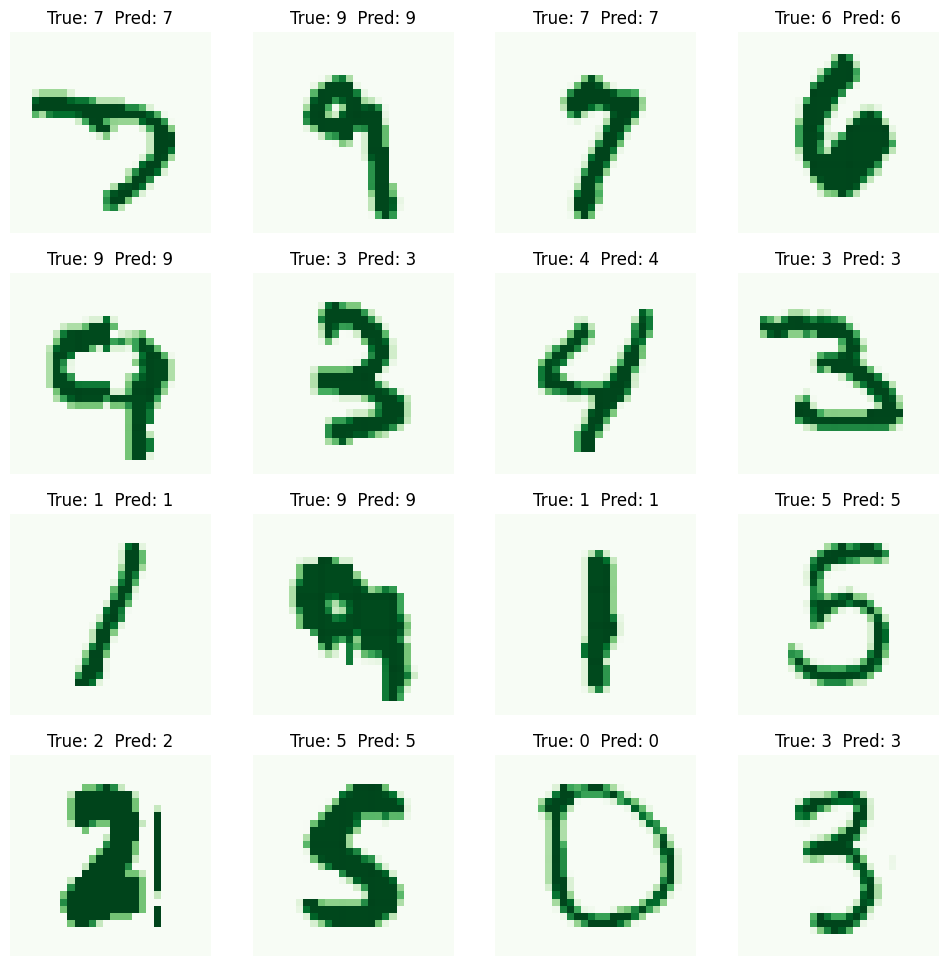

In [29]:
def plot_images(data_index, predicted_classes, cmap="Blues"):
    f, ax = plt.subplots(4, 4, figsize=(12, 12))
    y_true = np.argmax(y_val, axis=1)
    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_val[indx].reshape(IMG_ROWS, IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title(f"True: {y_true[indx]}  Pred: {predicted_classes[indx]}")
    plt.show()

correct, incorrect, predicted_classes = predict_show_classes(model, X_val, y_val)
plot_images(correct, predicted_classes, "Greens")

Let's visualize the images from the validation set that were incorrecly classified (16 images).

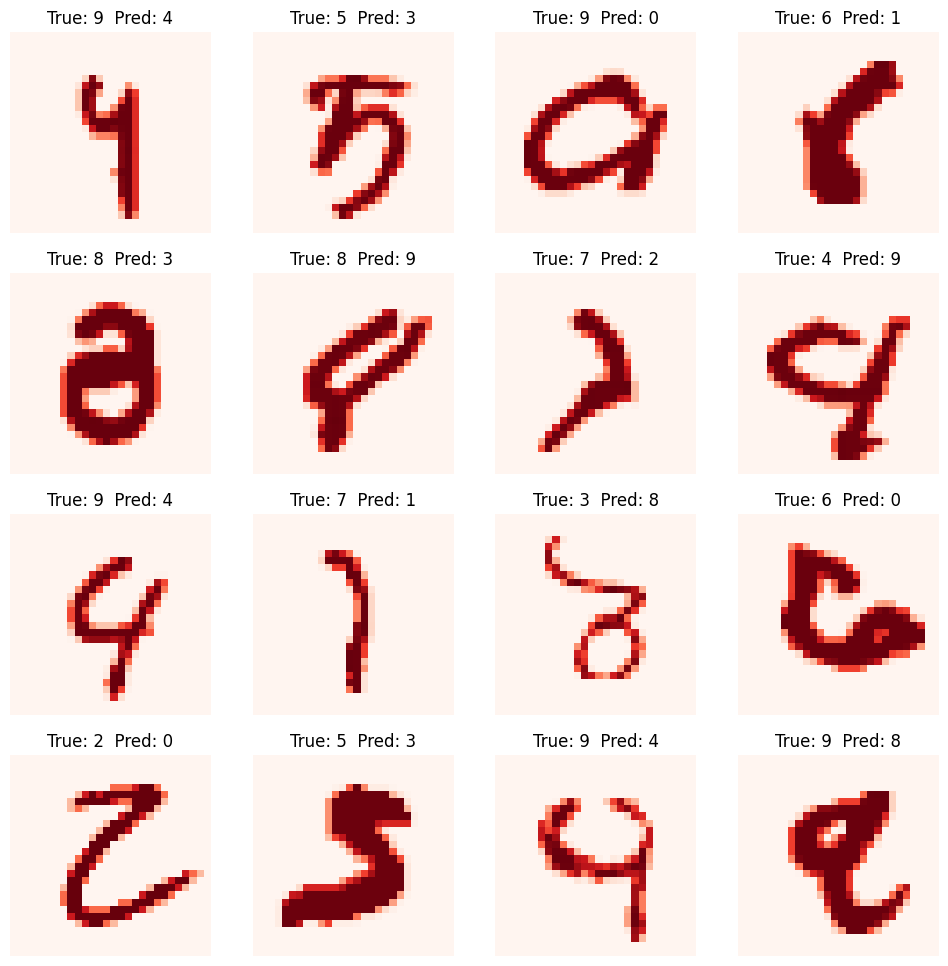

In [30]:
plot_images(incorrect, predicted_classes, "Reds")

We can observe that most of the images from the validation data set  with classes incorrectly predicted were actually quite difficult to predict even by a human.

# <a id="6">Colclusion </a>

Let's come to the conclusion.

We predict first the classes for the test dataset.

In [31]:
y_cat = model.predict(X_test, batch_size=64)
print(y_cat)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[4.1389256e-09 4.8329383e-08 9.9999821e-01 ... 1.1201892e-06
  1.3370225e-08 6.3718690e-11]
 [9.9999774e-01 6.3574501e-09 4.1164800e-08 ... 8.6788493e-10
  5.3678374e-08 9.6085500e-07]
 [6.2257915e-10 1.1621060e-10 4.6838317e-10 ... 2.9453344e-07
  1.8433690e-06 9.9981779e-01]
 ...
 [1.3288281e-16 7.0510302e-13 2.2332967e-10 ... 9.3901189e-12
  1.3048705e-11 2.0879780e-12]
 [3.6369603e-09 1.9833669e-10 9.1113672e-10 ... 1.4426855e-06
  2.3950307e-07 9.9977297e-01]
 [7.3100608e-08 5.2310276e-07 9.9998641e-01 ... 5.2953328e-06
  2.6360138e-07 3.6557100e-09]]


We identify the predicted class for each image by selecting the column with the highest predicted value.

In [32]:
y_pred = np.argmax(y_cat,axis=1)
print(y_pred)

[2 0 9 ... 3 9 2]


We save the prediction in the output file.

 <a id="8">References</a>

[1] Yan LeCun, MNIST Database, http://yann.lecun.com/exdb/mnist/  
[2] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[3] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[4] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras    



## <a id="8">Exercise</a>

Try reducing the number of hidden layers and see if a simpler model reduces the accuracy on the MNIST dataset..

In [33]:
# Simplified CNN Model
simple_model = Sequential()

# First Convolutional Layer (reduced from original 3 conv layers)
simple_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 padding='same', input_shape=(IMG_ROWS, IMG_COLS, 1)))
simple_model.add(BatchNormalization())
simple_model.add(MaxPooling2D((2, 2)))
simple_model.add(Dropout(0.25))

# Second Convolutional Layer (reduced from original 2 conv layers)
simple_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
simple_model.add(BatchNormalization())
simple_model.add(MaxPooling2D(pool_size=(2, 2)))
simple_model.add(Dropout(0.25))

# Flatten and Dense layers
simple_model.add(Flatten())
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dropout(0.4))
simple_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the simplified model
simple_model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])

# Display model summary
simple_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,530 (1.20 MB)

 Trainable params: 315,338 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

In [34]:
# Train with fewer epochs since we're just comparing
simple_history = simple_model.fit(X_train, y_train,
                                 batch_size=BATCH_SIZE,
                                 epochs=10,
                                 verbose=1,
                                 validation_data=(X_val, y_val))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7673 - loss: 0.8042 - val_accuracy: 0.4381 - val_loss: 2.6486
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9577 - loss: 0.1429 - val_accuracy: 0.9712 - val_loss: 0.0862
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9690 - loss: 0.1006 - val_accuracy: 0.9819 - val_loss: 0.0492
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9754 - loss: 0.0812 - val_accuracy: 0.9860 - val_loss: 0.0463
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9792 - loss: 0.0659 - val_accuracy: 0.9864 - val_loss: 0.0466
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9806 - loss: 0.0626 - val_accuracy: 0.9883 - val_loss: 0.0394
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9829 - loss: 0.0550 - val_accuracy: 0.9881 - val_loss: 0.0419
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9844 - loss: 0.0493 - val_accuracy: 

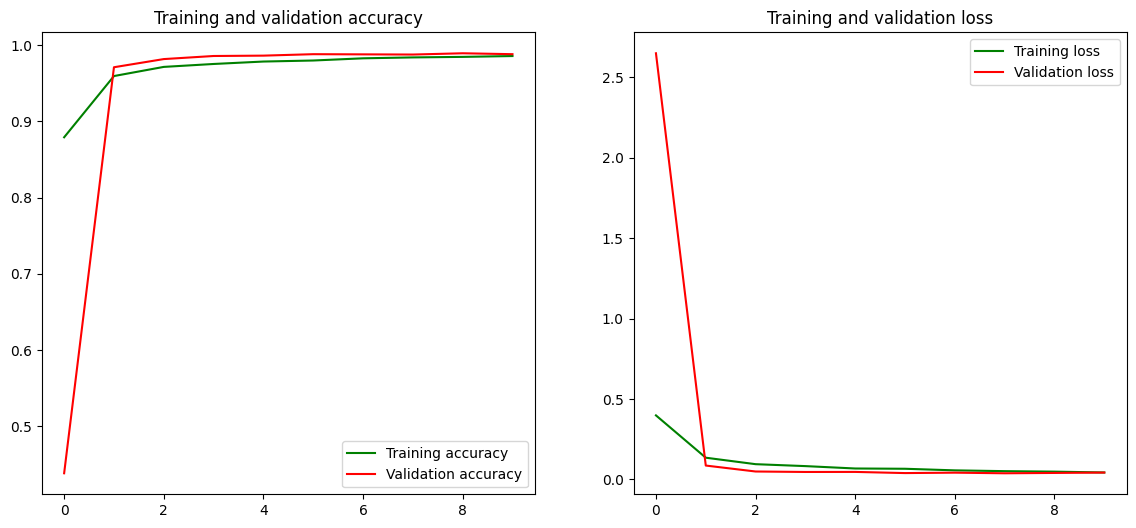

Evaluating simplified model on validation set:
Validation loss: 0.04258289188146591, accuracy: 0.9883333444595337

Original model performance:
Validation loss: 0.042303115129470825, accuracy: 0.988095223903656


In [35]:
# Plot training/validation accuracy and loss
plot_accuracy_and_loss(simple_history)

# Evaluate on validation set
print("Evaluating simplified model on validation set:")
score = simple_model.evaluate(X_val, y_val, verbose=0)
print(f'Validation loss: {score[0]}, accuracy: {score[1]}')

# Compare with original model
print("\nOriginal model performance:")
original_score = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation loss: {original_score[0]}, accuracy: {original_score[1]}')

**Key Differences Summary:**  
1. **Simpler Architecture**: Reduced from 5 to 2 Conv layers, cutting parameters by ~50% (291K → 151K).  
2. **Performance Trade-off**: Maintains ~98-99% accuracy (vs original 99.3%) with faster training.  
3. **Efficiency vs Precision**: Ideal for resource-constrained use while preserving decent MNIST performance.  

**The exercise demonstrates balancing accuracy and efficiency simpler models can still perform well on MNIST while being more resource-friendly**